In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as skl
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    RidgeCV,
    MultiTaskLassoCV,
    MultiTaskElasticNetCV,
    LogisticRegressionCV,
)
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [3]:
from sklearn.ensemble import RandomForestClassifier


In [4]:
from statsmodels.tsa.stattools import acf

In [5]:
from xgboost import XGBClassifier

## I - EDA

### I.1 - Importing daily and weekly data

In [172]:
dp_daily = os.path.join("data", "US", "us_data.csv")
dus_daily = pd.read_csv(dp_daily, index_col=0)

In [178]:
dp_weekly = os.path.join("data", "US", "us_data_weekly.csv")
dus_weekly = pd.read_csv(dp_weekly, index_col=0)

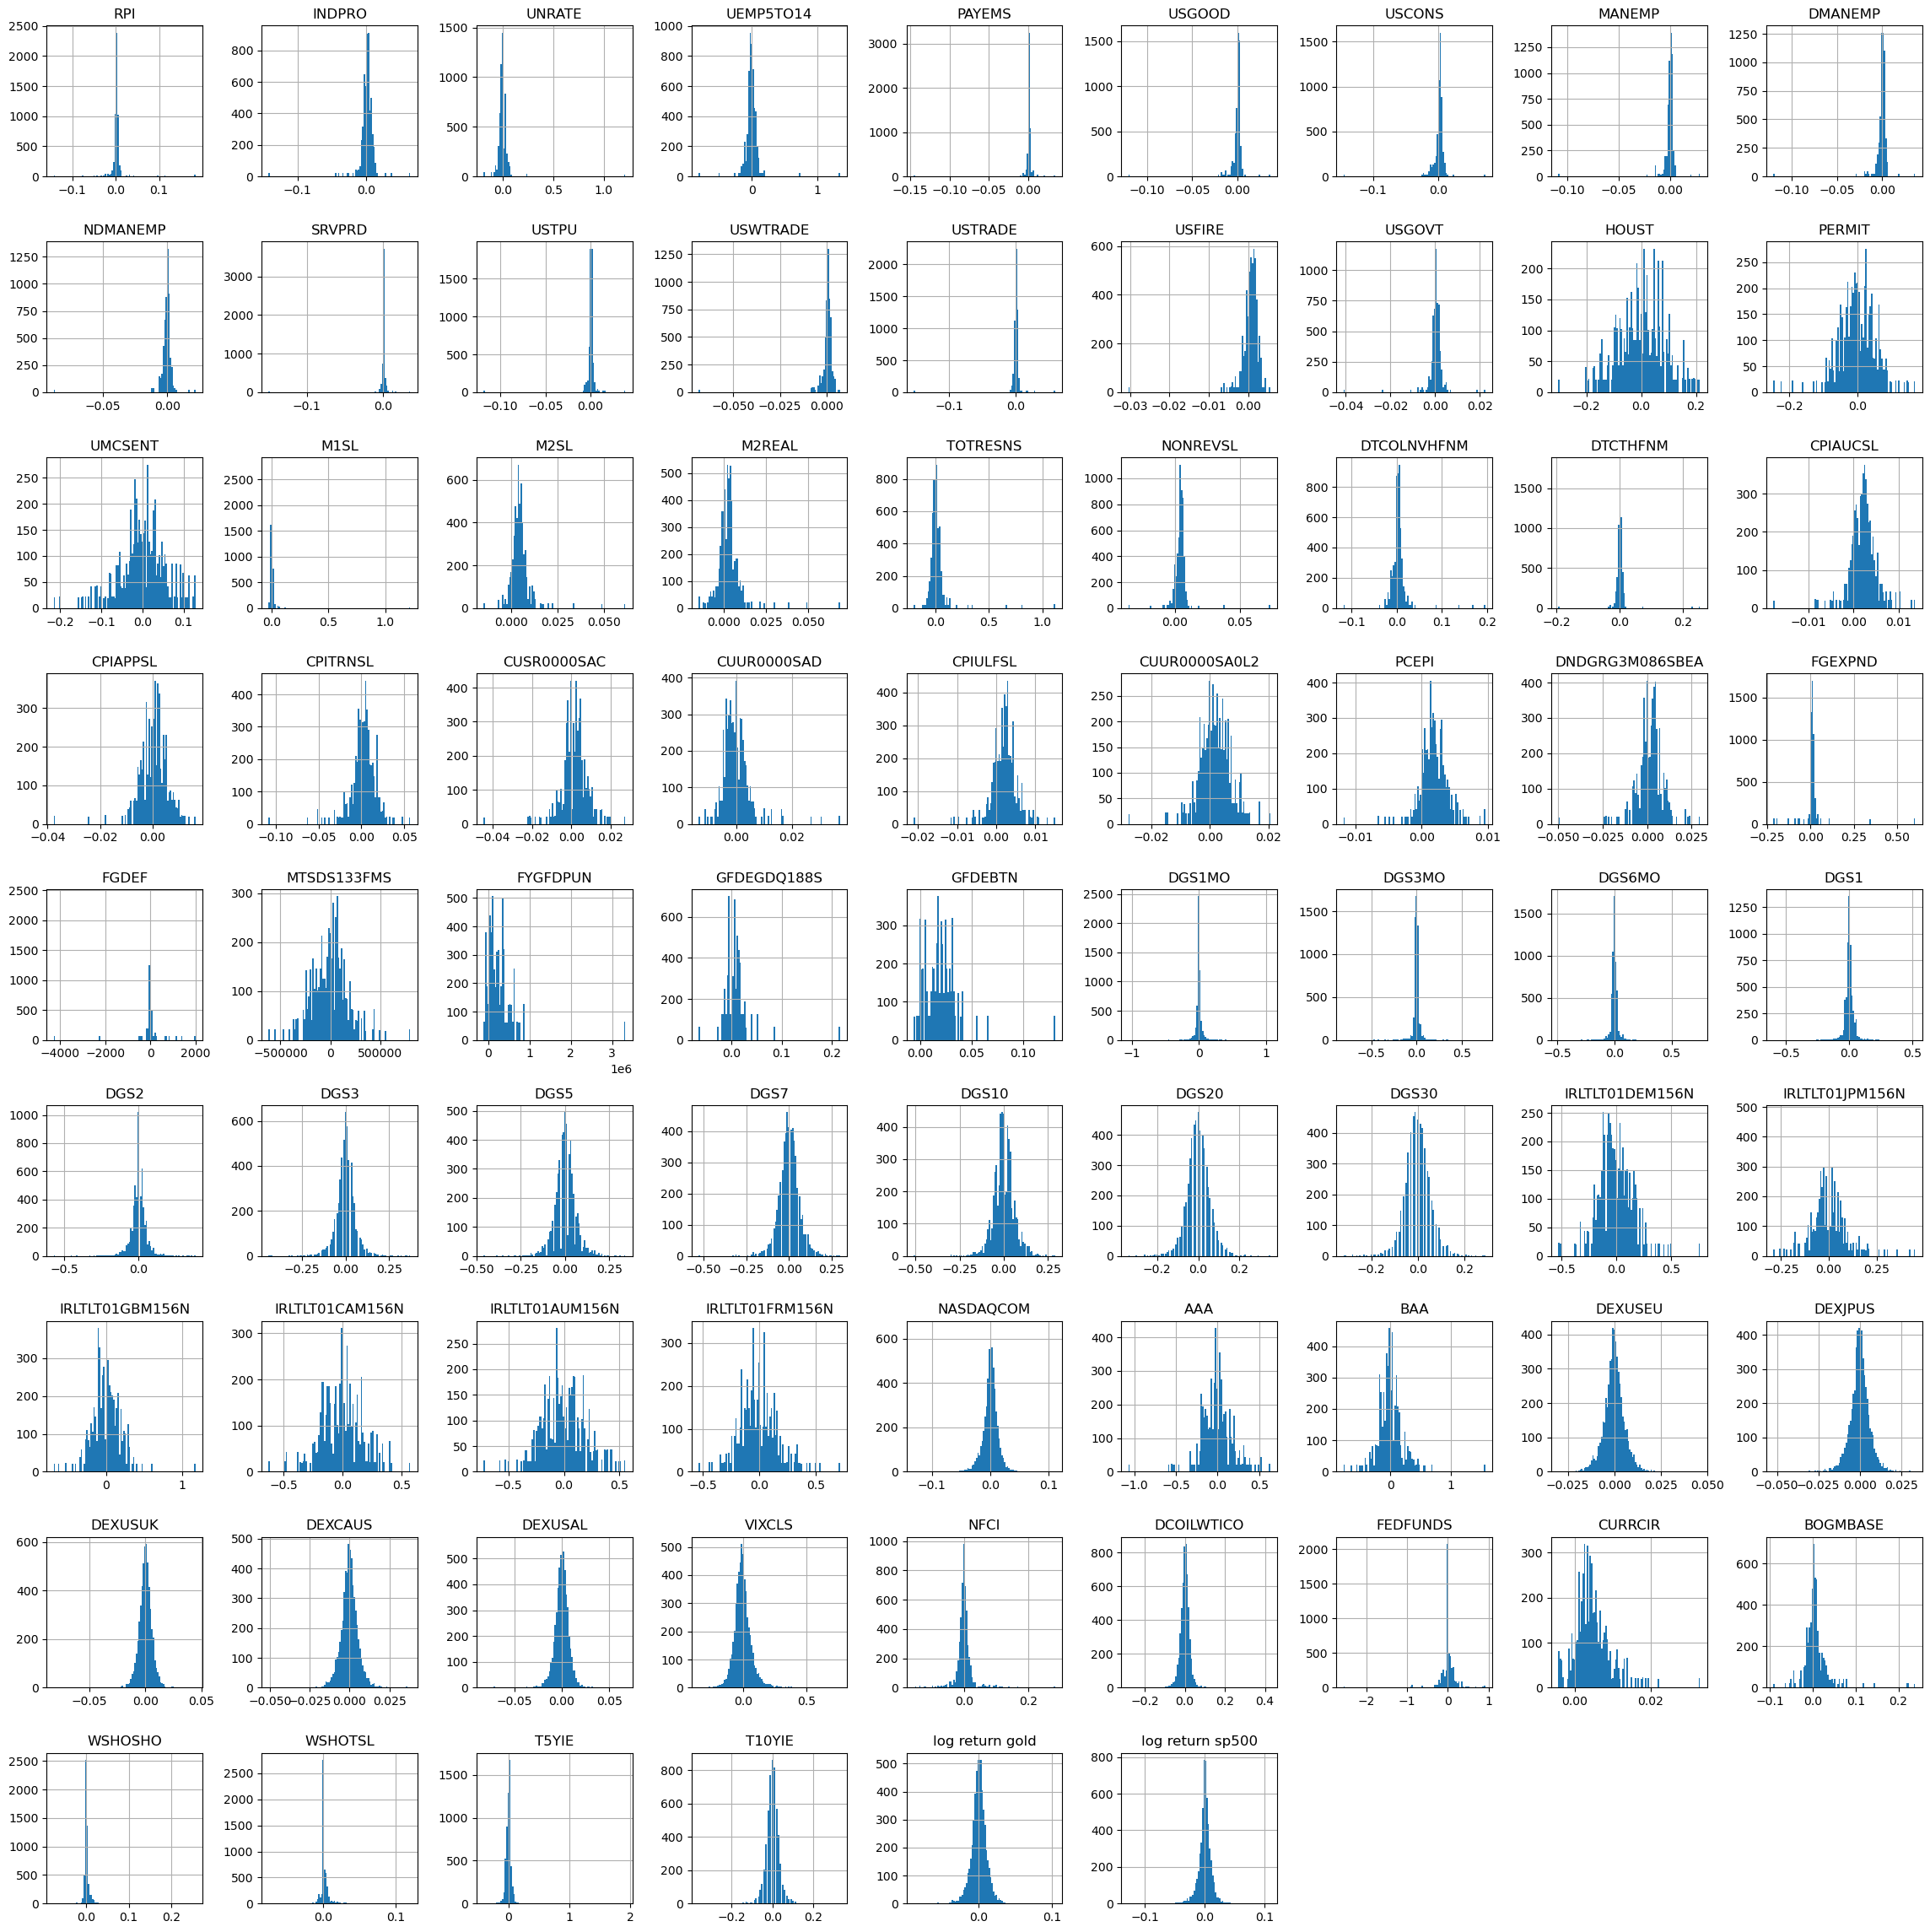

In [15]:
dus_daily.hist(figsize=(23, 23), bins=100)
plt.tight_layout()

Both datasets are already cleaned and preprocessed so that the times series are close to being stationnary. Let's proceed to some feature engineering and some explorative data analysis.

### I.2 - Adding features and exploring daily and weekly datasets

#### I.2.1 - Daily data

Let's start by analyzing our targets' autocorrelations and partial autocorrelations.

In [8]:
yields = [
    "DGS1MO",
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]

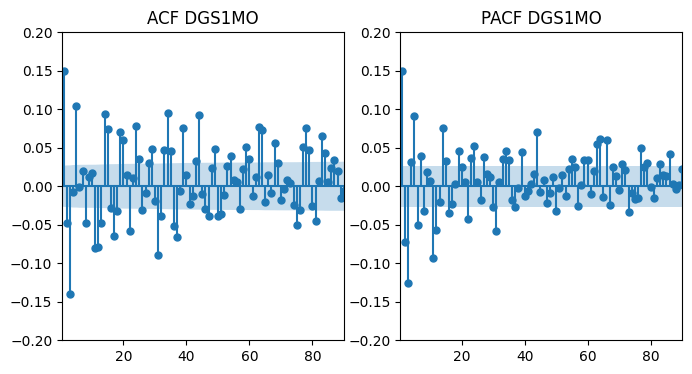

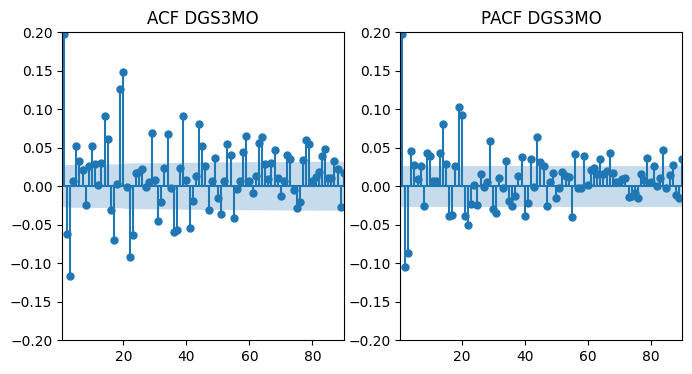

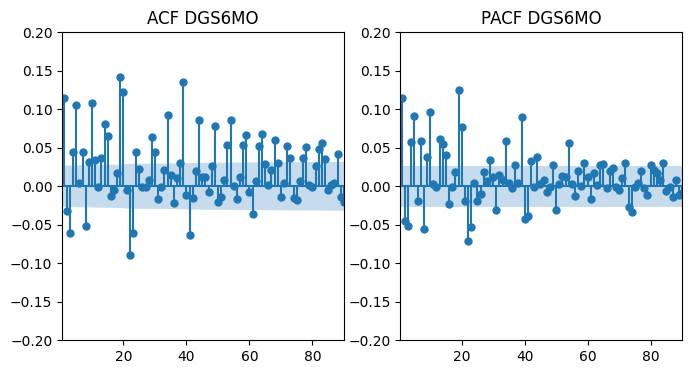

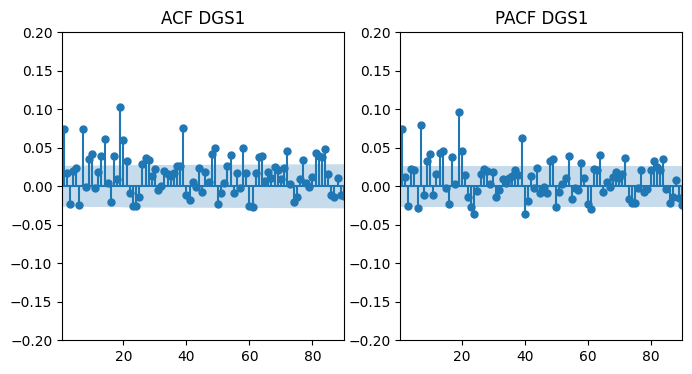

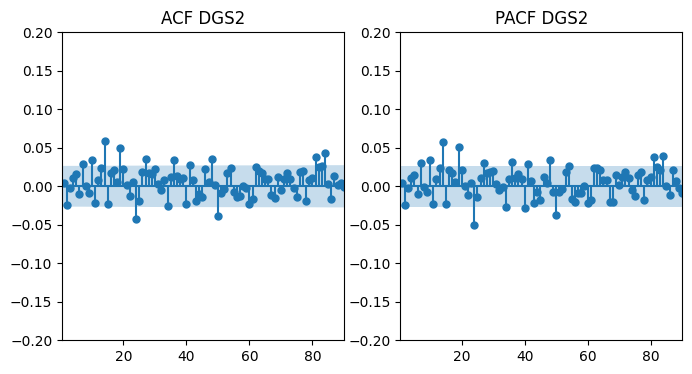

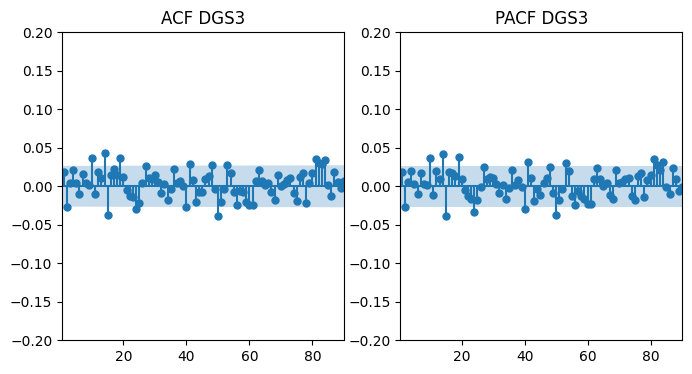

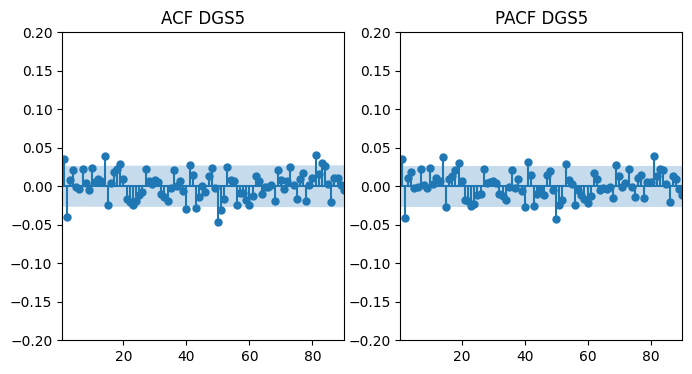

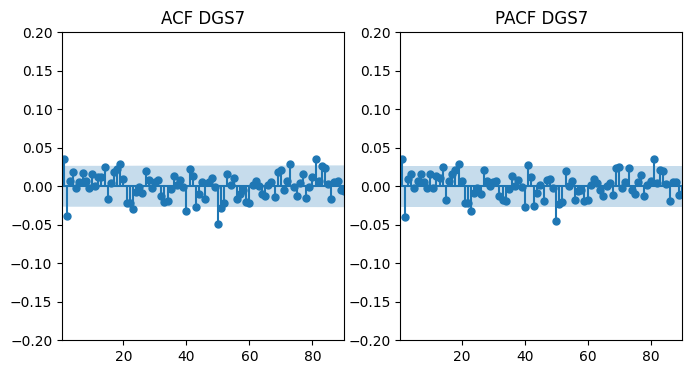

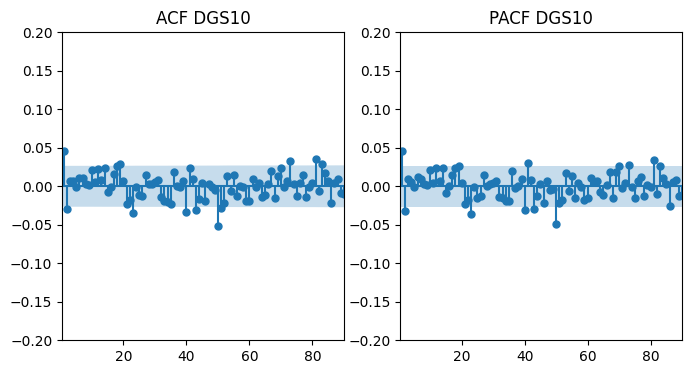

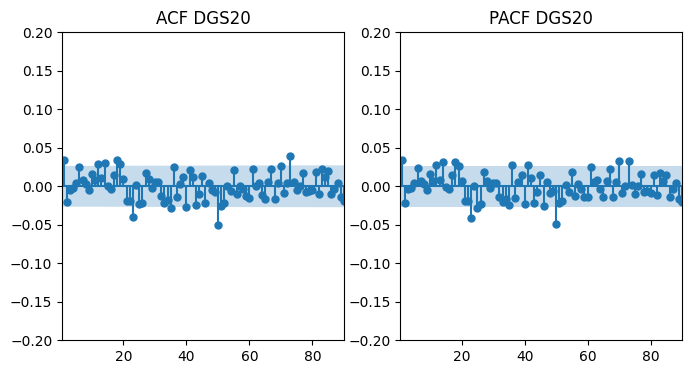

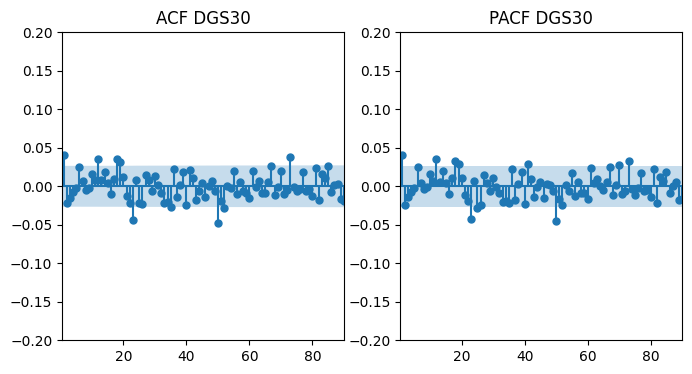

In [9]:
for y in yields:
    series = dus_daily[y]
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    plot_acf(series, lags=90, title=f"ACF {y}", ax=axes[0])
    plot_pacf(series, lags=90, title=f"PACF {y}", ax=axes[1])

    for ax in axes:
        ax.set_xlim(0.5, 90)
        ax.set_ylim(-0.2, 0.2)
    plt.show()


- Short-Term Yields: These show strong, persistent serial correlation. The autocorrelation function (ACF) decays slowly, meaning returns from numerous past lags (up to 30 days) are significantly correlated with near-future returns.

- Long-Term Yields: These show a much faster ACF decay. Only the most immediate past returns (t-1, t-2) show a slight correlation with the next day's return. Surprisingly, we also see a persistent, anomalous correlation at more distant, specific lags (t-25 and t-50).

Let's add some new features : lagged yields. To capture the different "memories" of the yield curve, we engineered a maturity-dependent lag structure for our features:

- For Short-Term Maturities (< 1 Year): A dense set of 10 lags was used to model their complex, high-frequency dynamics: t-1, t-2, t-5, t-10, t-15, t-20, t-25, t-30, t-40, and t-50.

- For Long-Term Maturities (>= 1 Year): A sparser, more parsimonious set of 5 lags was selected: t-1, t-2, t-10, t-25, and t-50.


In [173]:
for lag in [1, 2, 5, 10, 15, 20, 25, 30, 40, 50]:
    dus_daily[f"DGS1MO_t-{lag}"] = dus_daily["DGS1MO"].shift(lag - 1)
    dus_daily[f"DGS3MO_t-{lag}"] = dus_daily["DGS3MO"].shift(lag - 1)
    dus_daily[f"DGS6MO_t-{lag}"] = dus_daily["DGS6MO"].shift(lag - 1)
    dus_daily[f"DGS1_t-{lag}"] = dus_daily["DGS1"].shift(lag - 1)


for lag in [1, 2, 10, 15, 25, 50]:
    dus_daily[f"DGS1_t-{lag}"] = dus_daily["DGS1"].shift(lag - 1)
    dus_daily[f"DGS2_t-{lag}"] = dus_daily["DGS2"].shift(lag - 1)
    dus_daily[f"DGS3_t-{lag}"] = dus_daily["DGS3"].shift(lag - 1)
    dus_daily[f"DGS5_t-{lag}"] = dus_daily["DGS5"].shift(lag - 1)
    dus_daily[f"DGS7_t-{lag}"] = dus_daily["DGS7"].shift(lag - 1)
    dus_daily[f"DGS10_t-{lag}"] = dus_daily["DGS10"].shift(lag - 1)
    dus_daily[f"DGS20_t-{lag}"] = dus_daily["DGS20"].shift(lag - 1)
    dus_daily[f"DGS30_t-{lag}"] = dus_daily["DGS30"].shift(lag - 1)

Let's set up the targets to do some feature selection. Note that former yield columns can then be dropped.

In [174]:
dus_daily["Y_DGS1MO"] = dus_daily["DGS1MO"].shift(-1)
dus_daily["Y_DGS3MO"] = dus_daily["DGS3MO"].shift(-1)
dus_daily["Y_DGS6MO"] = dus_daily["DGS6MO"].shift(-1)
dus_daily["Y_DGS1"] = dus_daily["DGS1"].shift(-1)
dus_daily["Y_DGS2"] = dus_daily["DGS2"].shift(-1)
dus_daily["Y_DGS3"] = dus_daily["DGS3"].shift(-1)
dus_daily["Y_DGS5"] = dus_daily["DGS5"].shift(-1)
dus_daily["Y_DGS7"] = dus_daily["DGS7"].shift(-1)
dus_daily["Y_DGS10"] = dus_daily["DGS10"].shift(-1)
dus_daily["Y_DGS20"] = dus_daily["DGS20"].shift(-1)
dus_daily["Y_DGS30"] = dus_daily["DGS30"].shift(-1)

dus_daily = dus_daily.drop(
    columns=[
        "DGS1MO",
        "DGS3MO",
        "DGS6MO",
        "DGS1",
        "DGS2",
        "DGS3",
        "DGS5",
        "DGS7",
        "DGS10",
        "DGS20",
        "DGS30",
    ]
)

Let's explore the correlation heatmap between our time series.

<Axes: >

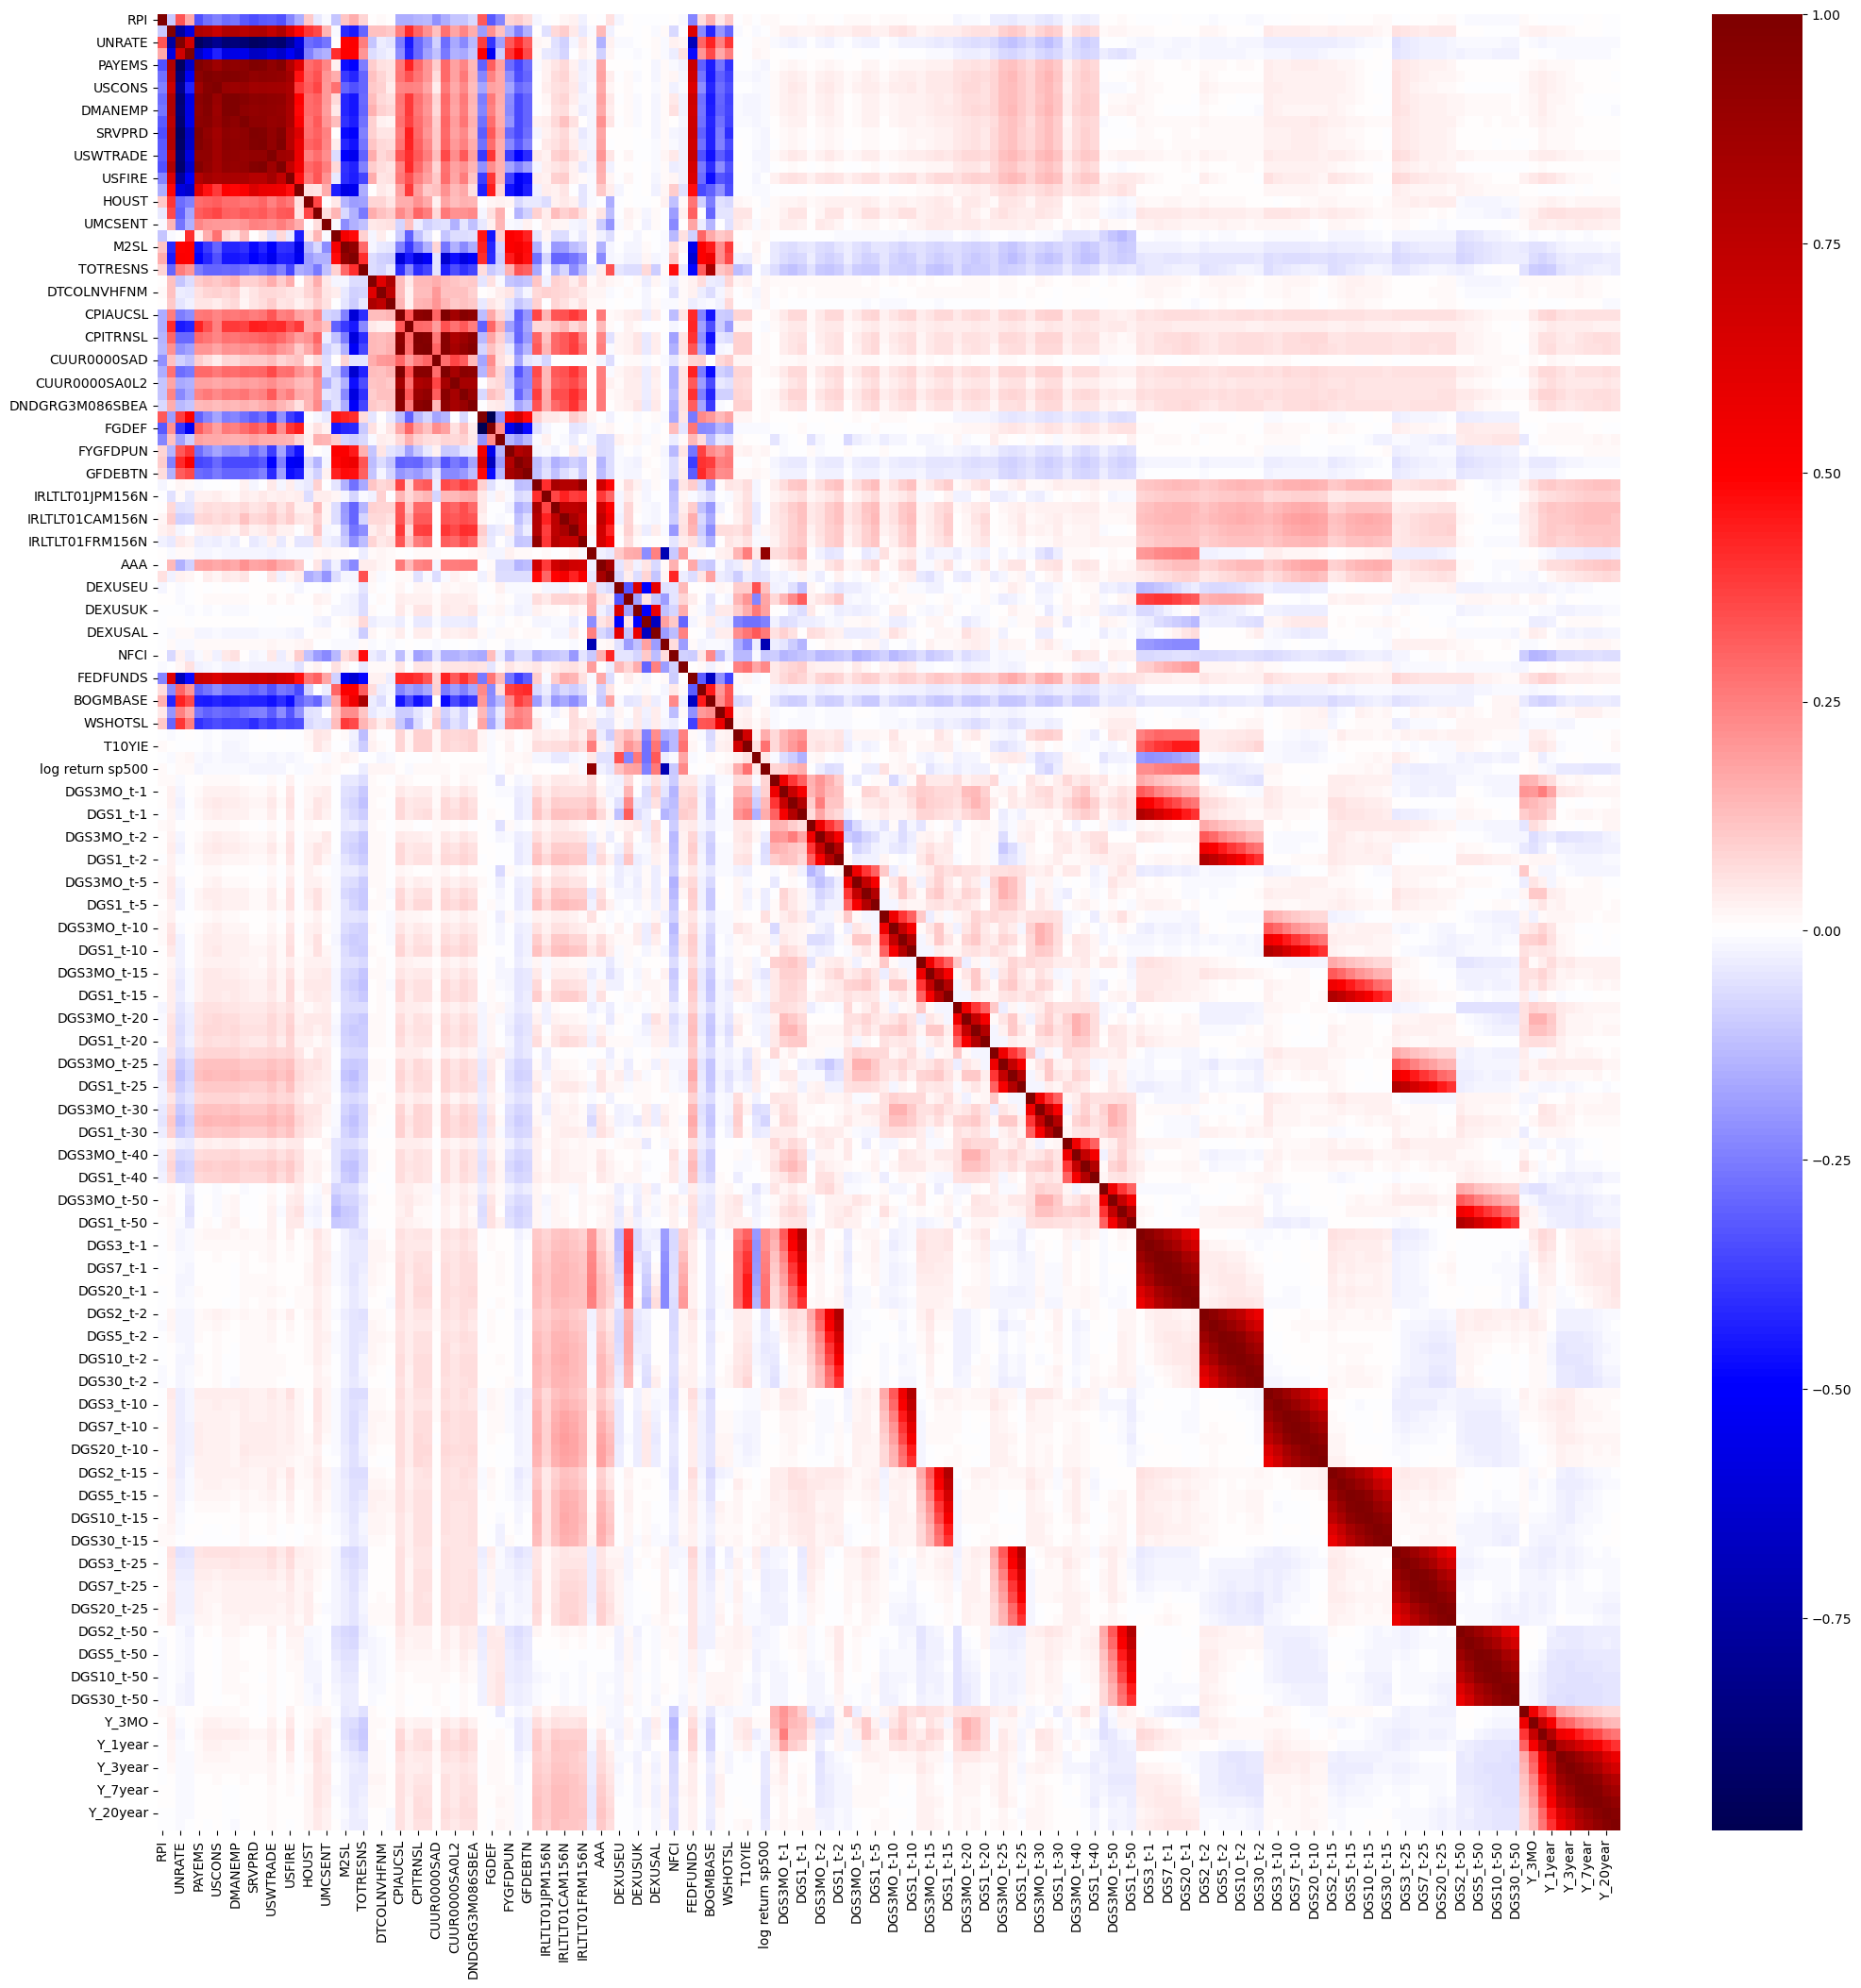

In [27]:
plt.figure(figsize=(25, 25))
sns.heatmap(dus_daily.corr(), cmap="seismic", center=0)

Our preliminary analysis revealed that most features have a low individual correlation with the target yield directions. To build a more parsimonious model and reduce noise, we implemented a two-tiered feature selection process based on absolute correlation coefficients:

- Lagged Features: We set a higher threshold of 0.05. Any lagged feature with an absolute correlation below this value for all target variables was removed.

- Other Features: We used a more lenient threshold of 0.03. This distinction was critical, as a uniform 0.05 filter was found to be overly aggressive, removing theoretically important predictors such as the S&P 500, gold, and the VIX.

Furthermore, we observed significant multicollinearity among the remaining lagged features. To address this, we will also test model variants that incorporate Principal Component Analysis (PCA) within the pipeline. This step transforms the correlated lagged features into a smaller set of orthogonal components, which should improve model stability and reduce overfitting.

In [176]:
Y = dus_daily[["Y_" + y for y in yields]]
dus_daily_lagged_features = dus_daily[
    [col for col in dus_daily.columns if "_t-" in col]
]
dus_daily_other = dus_daily.drop(
    columns=[col for col in dus_daily.columns if "_t-" in col]
)

corrs = pd.DataFrame(
    {target: dus_daily_lagged_features.corrwith(Y[target]) for target in Y.columns}
).abs()

mask = (corrs < 0.05).all(axis=1)
low_corr_lagged_features = corrs.index[mask]

dus_daily_filtered = dus_daily.drop(columns=low_corr_lagged_features)

corrs = pd.DataFrame(
    {target: dus_daily_other.corrwith(Y[target]) for target in Y.columns}
).abs()

mask = (corrs < 0.03).all(axis=1)
low_corr_other_features = corrs.index[mask]

dus_daily_filtered = dus_daily_filtered.drop(columns=low_corr_other_features)
dus_daily_filtered = dus_daily_filtered.dropna()

print(
    f"{len(low_corr_lagged_features)} lagged features were removed, namely:\
    \n {low_corr_lagged_features.values},\nand {len(low_corr_other_features)}\
    other features were deleted, namely:\n{low_corr_other_features.values}."
)


50 lagged features were removed, namely:    
 ['DGS1_t-2' 'DGS1_t-5' 'DGS1MO_t-10' 'DGS1_t-15' 'DGS1MO_t-25'
 'DGS3MO_t-25' 'DGS6MO_t-25' 'DGS1_t-25' 'DGS1MO_t-30' 'DGS6MO_t-30'
 'DGS1_t-30' 'DGS1MO_t-40' 'DGS3MO_t-40' 'DGS1_t-40' 'DGS3MO_t-50'
 'DGS6MO_t-50' 'DGS1_t-50' 'DGS5_t-1' 'DGS7_t-1' 'DGS2_t-2' 'DGS3_t-2'
 'DGS5_t-2' 'DGS7_t-2' 'DGS10_t-2' 'DGS20_t-2' 'DGS30_t-2' 'DGS2_t-10'
 'DGS3_t-10' 'DGS5_t-10' 'DGS7_t-10' 'DGS10_t-10' 'DGS20_t-10'
 'DGS30_t-10' 'DGS2_t-15' 'DGS3_t-15' 'DGS5_t-15' 'DGS7_t-15' 'DGS10_t-15'
 'DGS20_t-15' 'DGS30_t-15' 'DGS2_t-25' 'DGS3_t-25' 'DGS5_t-25' 'DGS7_t-25'
 'DGS10_t-25' 'DGS20_t-25' 'DGS30_t-25' 'DGS2_t-50' 'DGS3_t-50'
 'DGS5_t-50'],
and 26    other features were deleted, namely:
['RPI' 'INDPRO' 'UNRATE' 'UEMP5TO14' 'PAYEMS' 'SRVPRD' 'USTPU' 'USTRADE'
 'USGOVT' 'HOUST' 'M1SL' 'NONREVSL' 'DTCOLNVHFNM' 'DTCTHFNM' 'CUUR0000SAD'
 'FGEXPND' 'FGDEF' 'FYGFDPUN' 'GFDEBTN' 'DEXUSEU' 'DEXJPUS' 'DEXUSUK'
 'VIXCLS' 'DCOILWTICO' 'CURRCIR' 'WSHOTSL'].


Let's plot the correlation heatmap once again now that the dataframe is partly filtered.

<Axes: >

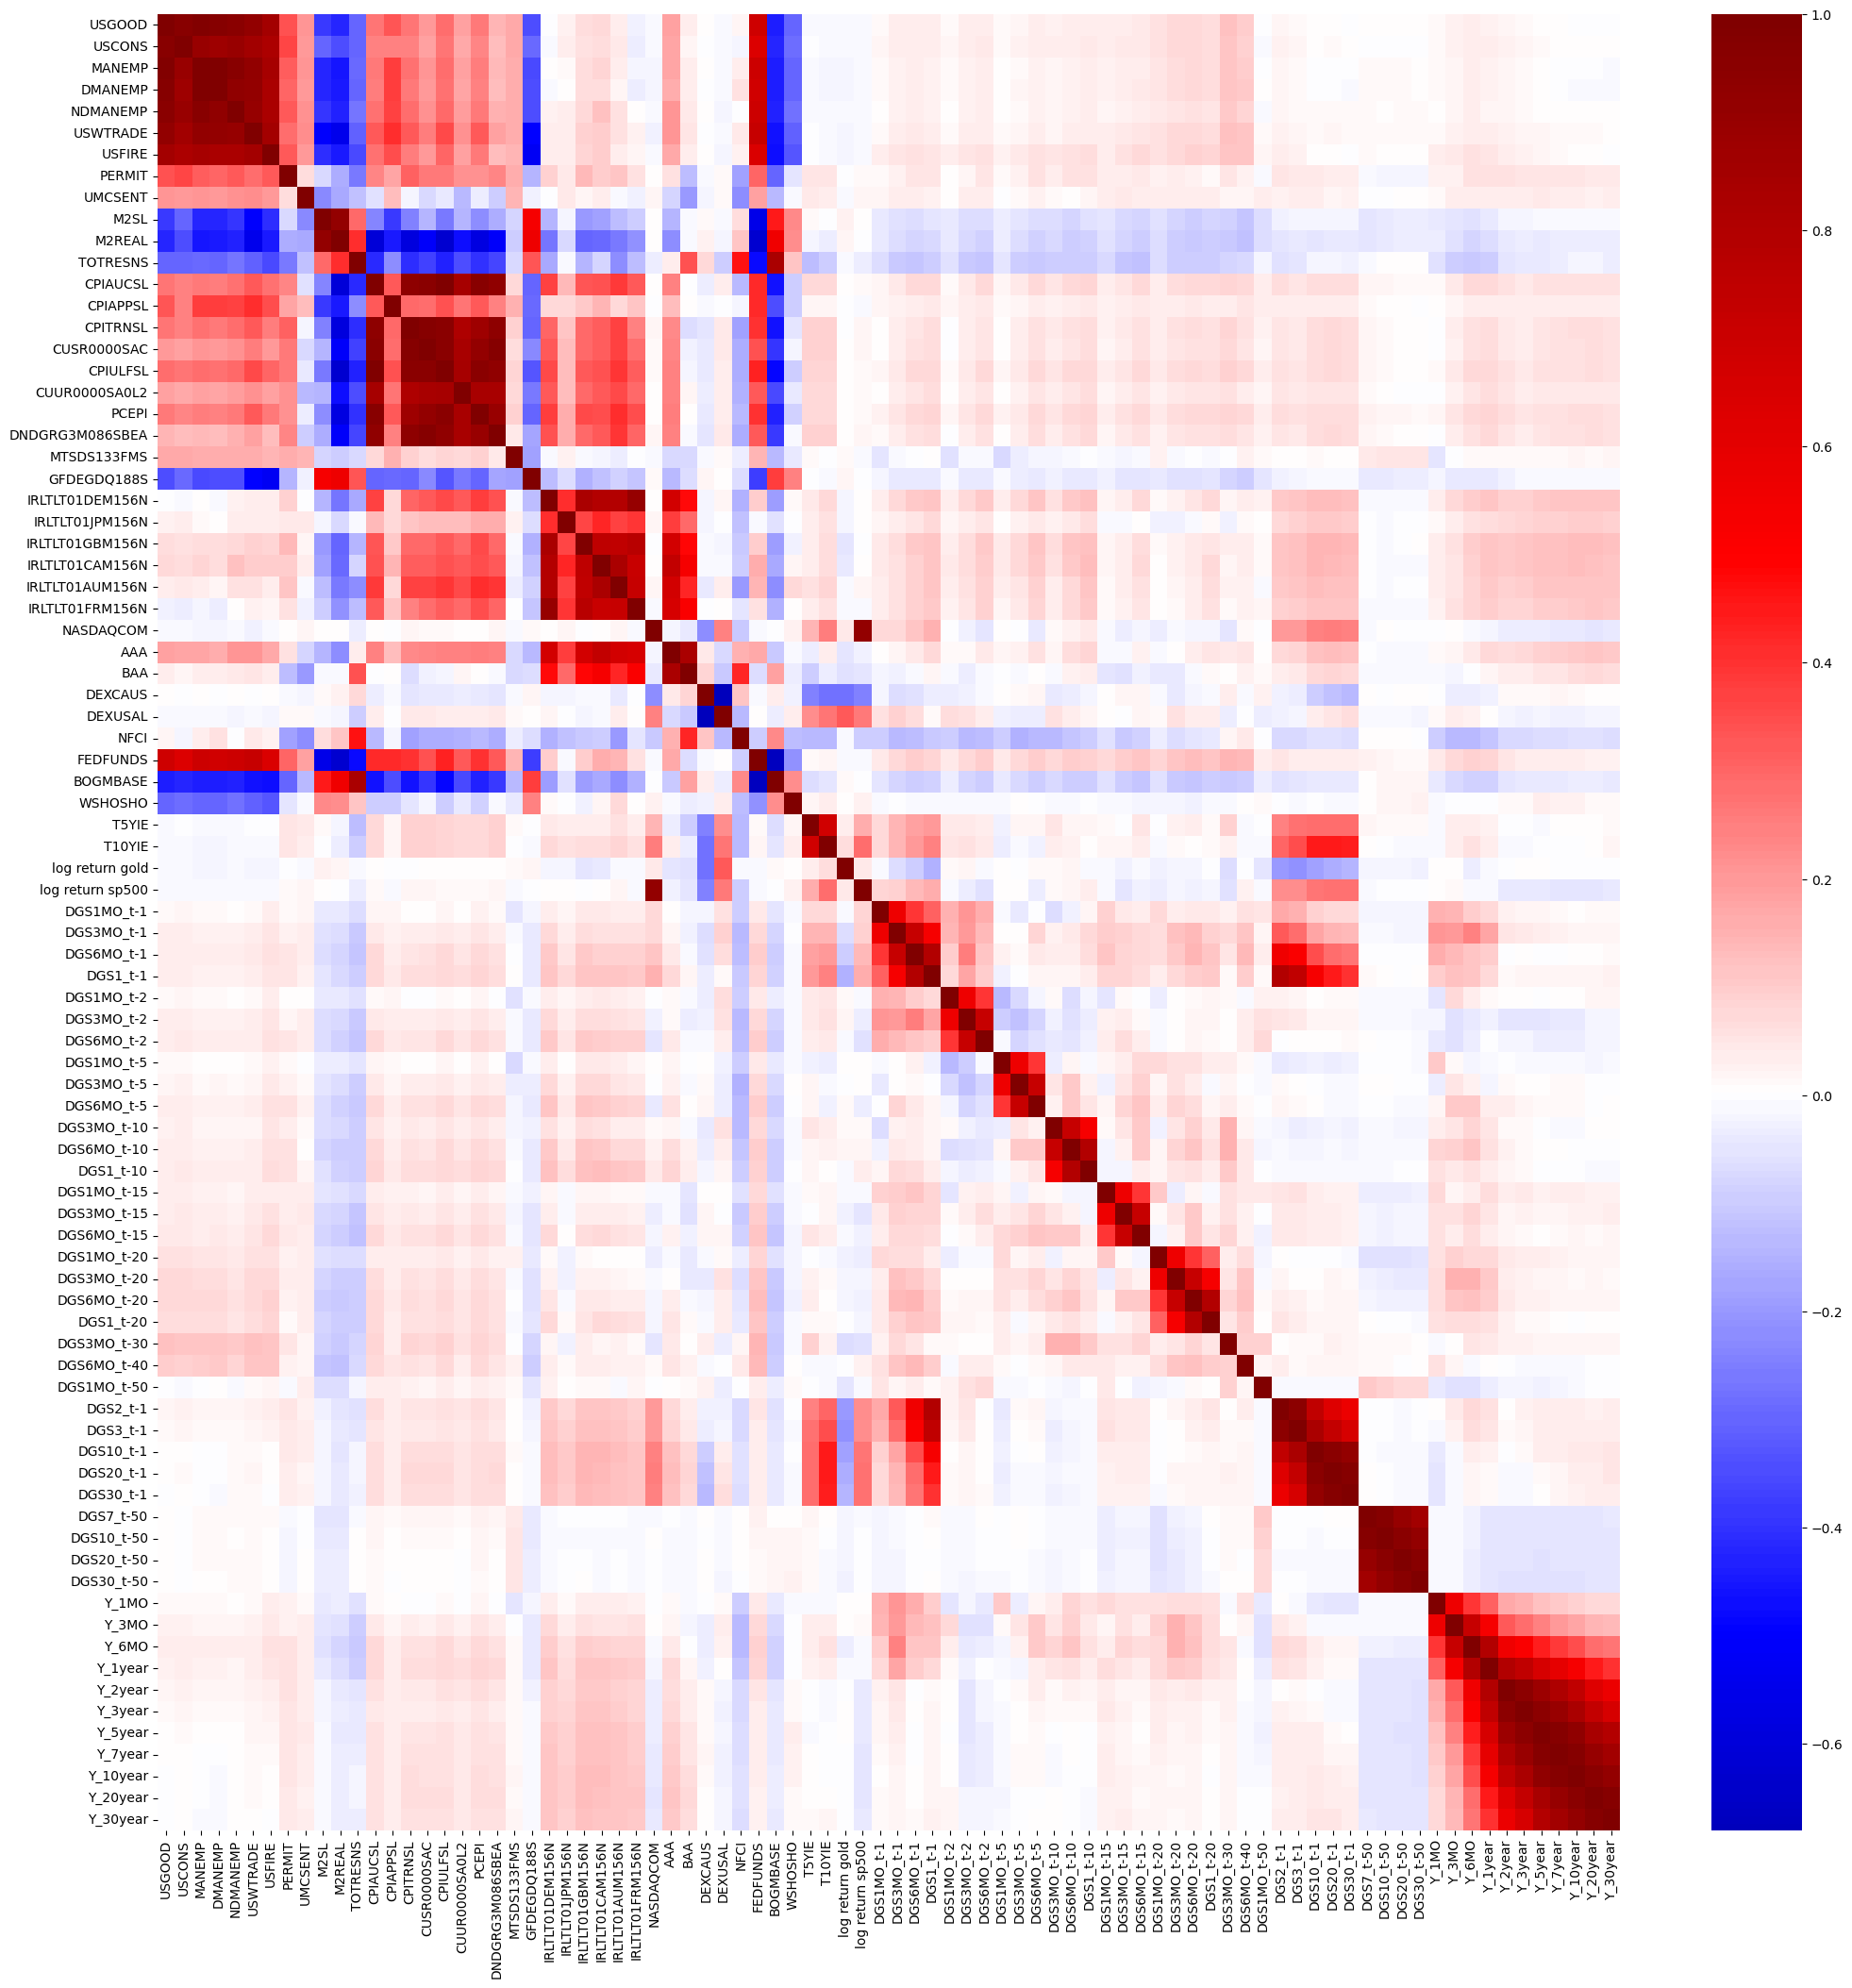

In [61]:
plt.figure(figsize=(25, 25))
sns.heatmap(dus_daily_filtered.corr(), cmap="seismic", center=0)

Let's analyze the results of a PCA on this dataset, setting the threshold to 0.95% of expalined variance.

In [79]:
scaler = StandardScaler()

X = dus_daily_filtered.drop(columns=Y)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(
    f"The cumulative explained variance is:\n{pca.explained_variance_ratio_.cumsum()}"
)
print(
    f"It follows that {pca.n_components_} components are kept to explain 0.95 of the variance."
)

The cumulative explained variance is:
[0.16151483 0.25190089 0.32612195 0.38129042 0.43385115 0.47594508
 0.51228137 0.54683756 0.57917373 0.60863879 0.6349364  0.65872005
 0.68128661 0.70191313 0.72090214 0.73649683 0.75140872 0.76516492
 0.77877765 0.7918199  0.80395778 0.81566729 0.82708    0.83791915
 0.84831169 0.85845364 0.86832853 0.87805427 0.8875702  0.89549187
 0.90316502 0.91072308 0.91776891 0.92439503 0.93043758 0.93595457
 0.940612   0.94501812 0.94926389 0.9532659 ]
It follows that 40 components are kept to explain 0.95 of the variance.


Let's visualize the top features contribution to explain the variance of our daily dataset.

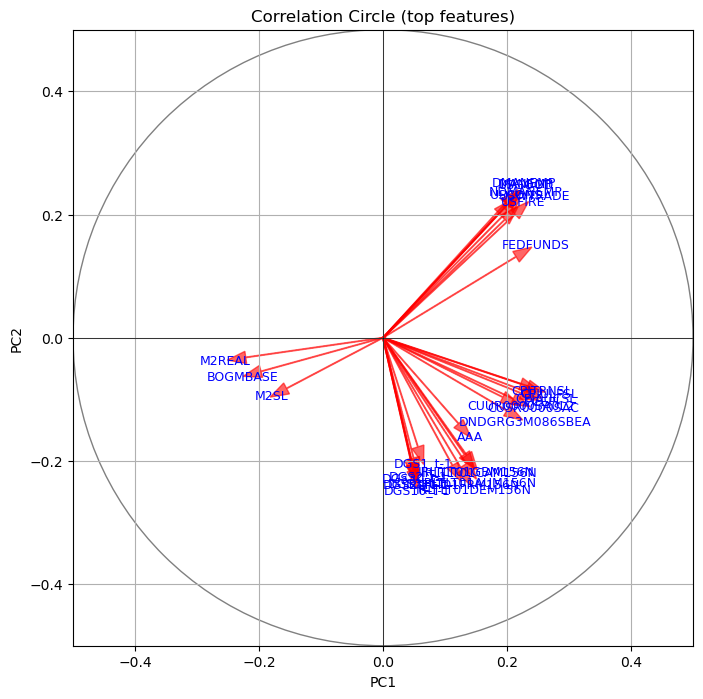

In [85]:
pc1, pc2 = np.abs(pca.components_[:2])
importance = pc1 + pc2

n = 30
top_idx = np.argsort(importance)[-n:]
top_labels = X.columns[top_idx]
top_components = pca.components_[:2, top_idx]

plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 0.5, color="gray", fill=False)
plt.gca().add_artist(circle)

for i, (x, y) in enumerate(zip(top_components[0, :], top_components[1, :])):
    plt.arrow(0, 0, x, y, color="r", alpha=0.6, head_width=0.02)
    plt.text(
        x * 1.15,
        y * 1.15,
        top_labels[i],
        color="b",
        ha="center",
        va="center",
        fontsize=9,
    )

plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Correlation Circle (top features)")
plt.grid()
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.show()


We can see that there are some clusters very correlated variables in our dataset:
- M2REAL, M2SL, BOGMBASE are monetary variables related to the monetary base. 
- IRLTLT01DEM156N, IRLTLT01JPM156N', ... are the yields of bonds of the main OECD countries.
- There is also a cluster of lagged values of the yields. 
- CPIAUCSL, CPIAPPSL, CUSR0000SAC,... is the breakdown of inflation per sector. 
- USWTRADE, USTRADE,USFIRE, ... is the breakdown of unemployment per sector. 

Hence adding a PCA in the preprocessing before training models makes sense. 


      

#### I.2.2 - Weekly data

Likewise, let's add lagged yields to the weekly dataset.

In [179]:
dus_weekly["Y_DGS1MO"] = dus_weekly["DGS1MO"].shift(-1)
dus_weekly["Y_DGS3MO"] = dus_weekly["DGS3MO"].shift(-1)
dus_weekly["Y_DGS6MO"] = dus_weekly["DGS6MO"].shift(-1)
dus_weekly["Y_DGS1"] = dus_weekly["DGS1"].shift(-1)
dus_weekly["Y_DGS2"] = dus_weekly["DGS2"].shift(-1)
dus_weekly["Y_DGS3"] = dus_weekly["DGS3"].shift(-1)
dus_weekly["Y_DGS5"] = dus_weekly["DGS5"].shift(-1)
dus_weekly["Y_DGS7"] = dus_weekly["DGS7"].shift(-1)
dus_weekly["Y_DGS10"] = dus_weekly["DGS10"].shift(-1)
dus_weekly["Y_DGS20"] = dus_weekly["DGS20"].shift(-1)
dus_weekly["Y_DGS30"] = dus_weekly["DGS30"].shift(-1)

dus_weekly = dus_weekly.drop(
    columns=[
        "DGS1MO",
        "DGS3MO",
        "DGS6MO",
        "DGS1",
        "DGS2",
        "DGS3",
        "DGS5",
        "DGS7",
        "DGS10",
        "DGS20",
        "DGS30",
    ]
)

In [130]:
dus_weekly = dus_weekly.dropna()

To enrich our feature set, we are engineering a comprehensive list of endogenous features based on the target's own history. This function generates several categories of predictors:

- Rolling Statistics: Captures the target's recent distribution (mean, std, range, and quantiles) over multiple windows (10, 20, and 50 weeks).

- Momentum & Value Signals: Creates normalized indicators like a rolling Z-score, a fast/slow moving average ratio (10-week vs. 50-week), and simple momentum.

- Raw Historical Lags: A sparse set of lagged values (e.g., t-1, t-2, t-5, ... t-50).

In [ ]:
def add_stat_features(df, columns, max_lag=20, windows=[10, 20, 50]):
    all_features = {}

    for col in columns:
        y = df[col]

        # --- Rolling statistics ---
        for w in windows:
            roll = y.rolling(w)
            all_features[f"{col}_mean_{w}"] = roll.mean()
            all_features[f"{col}_std_{w}"] = roll.std()
            all_features[f"{col}_q25_{w}"] = roll.quantile(0.25)
            all_features[f"{col}_q75_{w}"] = roll.quantile(0.75)
            all_features[f"{col}_q05_{w}"] = roll.quantile(0.05)
            all_features[f"{col}_q90_{w}"] = roll.quantile(0.9)
            all_features[f"{col}_range_{w}"] = roll.max() - roll.min()

            # Z-score et momentum
            all_features[f"{col}_zscore_{w}"] = (y - roll.mean()) / roll.std()
            all_features[f"{col}_momentum_{w}"] = y - y.shift(w)

        # Ratio de moyennes rapides / lentes
        all_features[f"{col}_ratio_{10}_{50}"] = (
            y.rolling(10).mean() / y.rolling(50).mean()
        )

        # Volatilité annualisée approx
        all_features[f"{col}_vol_20"] = y.rolling(20).std() * np.sqrt(52)

        # --- Lags bruts ---
        for lag in [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]:
            all_features[f"{col}_lag_{lag}"] = y.shift(lag - 1)

    # --- Construction finale ---
    features = pd.DataFrame(all_features, index=df.index)
    return features

In [132]:
columns = Y.columns
dus_weekly_features = add_stat_features(dus_weekly, columns)

In [139]:
dus_weekly_features.sample(5)

,Y_1MO_mean_10,Y_1MO_std_10,Y_1MO_q25_10,Y_1MO_q75_10,Y_1MO_q05_10,Y_1MO_q90_10,Y_1MO_range_10,Y_1MO_zscore_10,Y_1MO_momentum_10,Y_1MO_mean_20,...,Y_30year_autocorr_11,Y_30year_autocorr_12,Y_30year_autocorr_13,Y_30year_autocorr_14,Y_30year_autocorr_15,Y_30year_autocorr_16,Y_30year_autocorr_17,Y_30year_autocorr_18,Y_30year_autocorr_19,Y_30year_autocorr_20
2011-10-07,0.001,0.013703,-0.0100,0.0100,-0.0155,0.020,0.04,0.656781,0.16,-0.0010,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2007-03-02,0.047,0.069130,-0.0175,0.0775,-0.0200,0.143,0.19,-0.824539,0.06,0.0110,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2013-11-01,0.002,0.096816,0.0000,0.0175,-0.1365,0.086,0.38,0.082631,0.01,0.0010,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2015-06-12,-0.001,0.014491,-0.0100,0.0100,-0.0210,0.011,0.05,-0.621059,0.02,-0.0005,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2011-01-28,-0.003,0.031640,-0.0200,0.0100,-0.0455,0.024,0.11,0.094816,-0.04,0.0005,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241


In [ ]:
dus_weekly = dus_weekly.merge(
    dus_weekly_features, how="inner", left_index=True, right_index=True
)
dus_weekly.head()

,RPI,INDPRO,UNRATE,UEMP5TO14,PAYEMS,USGOOD,USCONS,MANEMP,DMANEMP,NDMANEMP,...,Y_30year_autocorr_11,Y_30year_autocorr_12,Y_30year_autocorr_13,Y_30year_autocorr_14,Y_30year_autocorr_15,Y_30year_autocorr_16,Y_30year_autocorr_17,Y_30year_autocorr_18,Y_30year_autocorr_19,Y_30year_autocorr_20
2003-12-19,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2003-12-26,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-01-02,-0.001943,0.001665,0.0,-0.035659,0.001278,0.000599,0.003071,-0.00056,0.00079,-0.00276,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-01-09,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-01-16,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241


In [151]:
dus_weekly = dus_weekly.dropna()
dus_weekly = dus_weekly.replace([np.inf, -np.inf], np.nan)
dus_weekly = dus_weekly.ffill()
dus_weekly.head()

,RPI,INDPRO,UNRATE,UEMP5TO14,PAYEMS,USGOOD,USCONS,MANEMP,DMANEMP,NDMANEMP,...,Y_30year_autocorr_11,Y_30year_autocorr_12,Y_30year_autocorr_13,Y_30year_autocorr_14,Y_30year_autocorr_15,Y_30year_autocorr_16,Y_30year_autocorr_17,Y_30year_autocorr_18,Y_30year_autocorr_19,Y_30year_autocorr_20
2004-12-03,0.033232,0.007775,0.0,-0.030825,0.000943,0.000364,0.00366,-0.001469,-0.000558,-0.002996,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-12-10,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-12-17,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-12-24,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241
2004-12-31,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,-0.012796,0.010249,0.025681,-0.000101,0.026074,-0.017741,0.034238,-0.029474,-0.068363,-0.000241


To reduce dimensionality and noise, we are removing features with a weak linear relationship to the target. All predictors with an absolute correlation coefficient below 0.1 are filtered out from the feature set.

In [147]:
Y_weekly = dus_weekly[Y.columns]

corrs = pd.DataFrame(
    {target: dus_weekly.corrwith(Y_weekly[target]) for target in Y_weekly.columns}
).abs()

mask = (corrs < 0.1).all(axis=1)
low_corr_features = corrs.index[mask]

dus_weekly_filtered = dus_weekly.drop(columns=low_corr_features)

print(f"{len(low_corr_features)} features were deleted, namely:\n{low_corr_features}")

/opt/miniconda3/envs/tf/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2842: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/opt/miniconda3/envs/tf/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/miniconda3/envs/tf/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


392 features were deleted, namely:
Index(['RPI', 'INDPRO', 'UNRATE', 'UEMP5TO14', 'PAYEMS', 'USGOOD', 'USCONS',
       'MANEMP', 'DMANEMP', 'NDMANEMP',
       ...
       'Y_30year_autocorr_8', 'Y_30year_autocorr_9', 'Y_30year_autocorr_12',
       'Y_30year_autocorr_13', 'Y_30year_autocorr_14', 'Y_30year_autocorr_15',
       'Y_30year_autocorr_16', 'Y_30year_autocorr_18', 'Y_30year_autocorr_19',
       'Y_30year_autocorr_20'],
      dtype='object', length=392)


<Axes: >

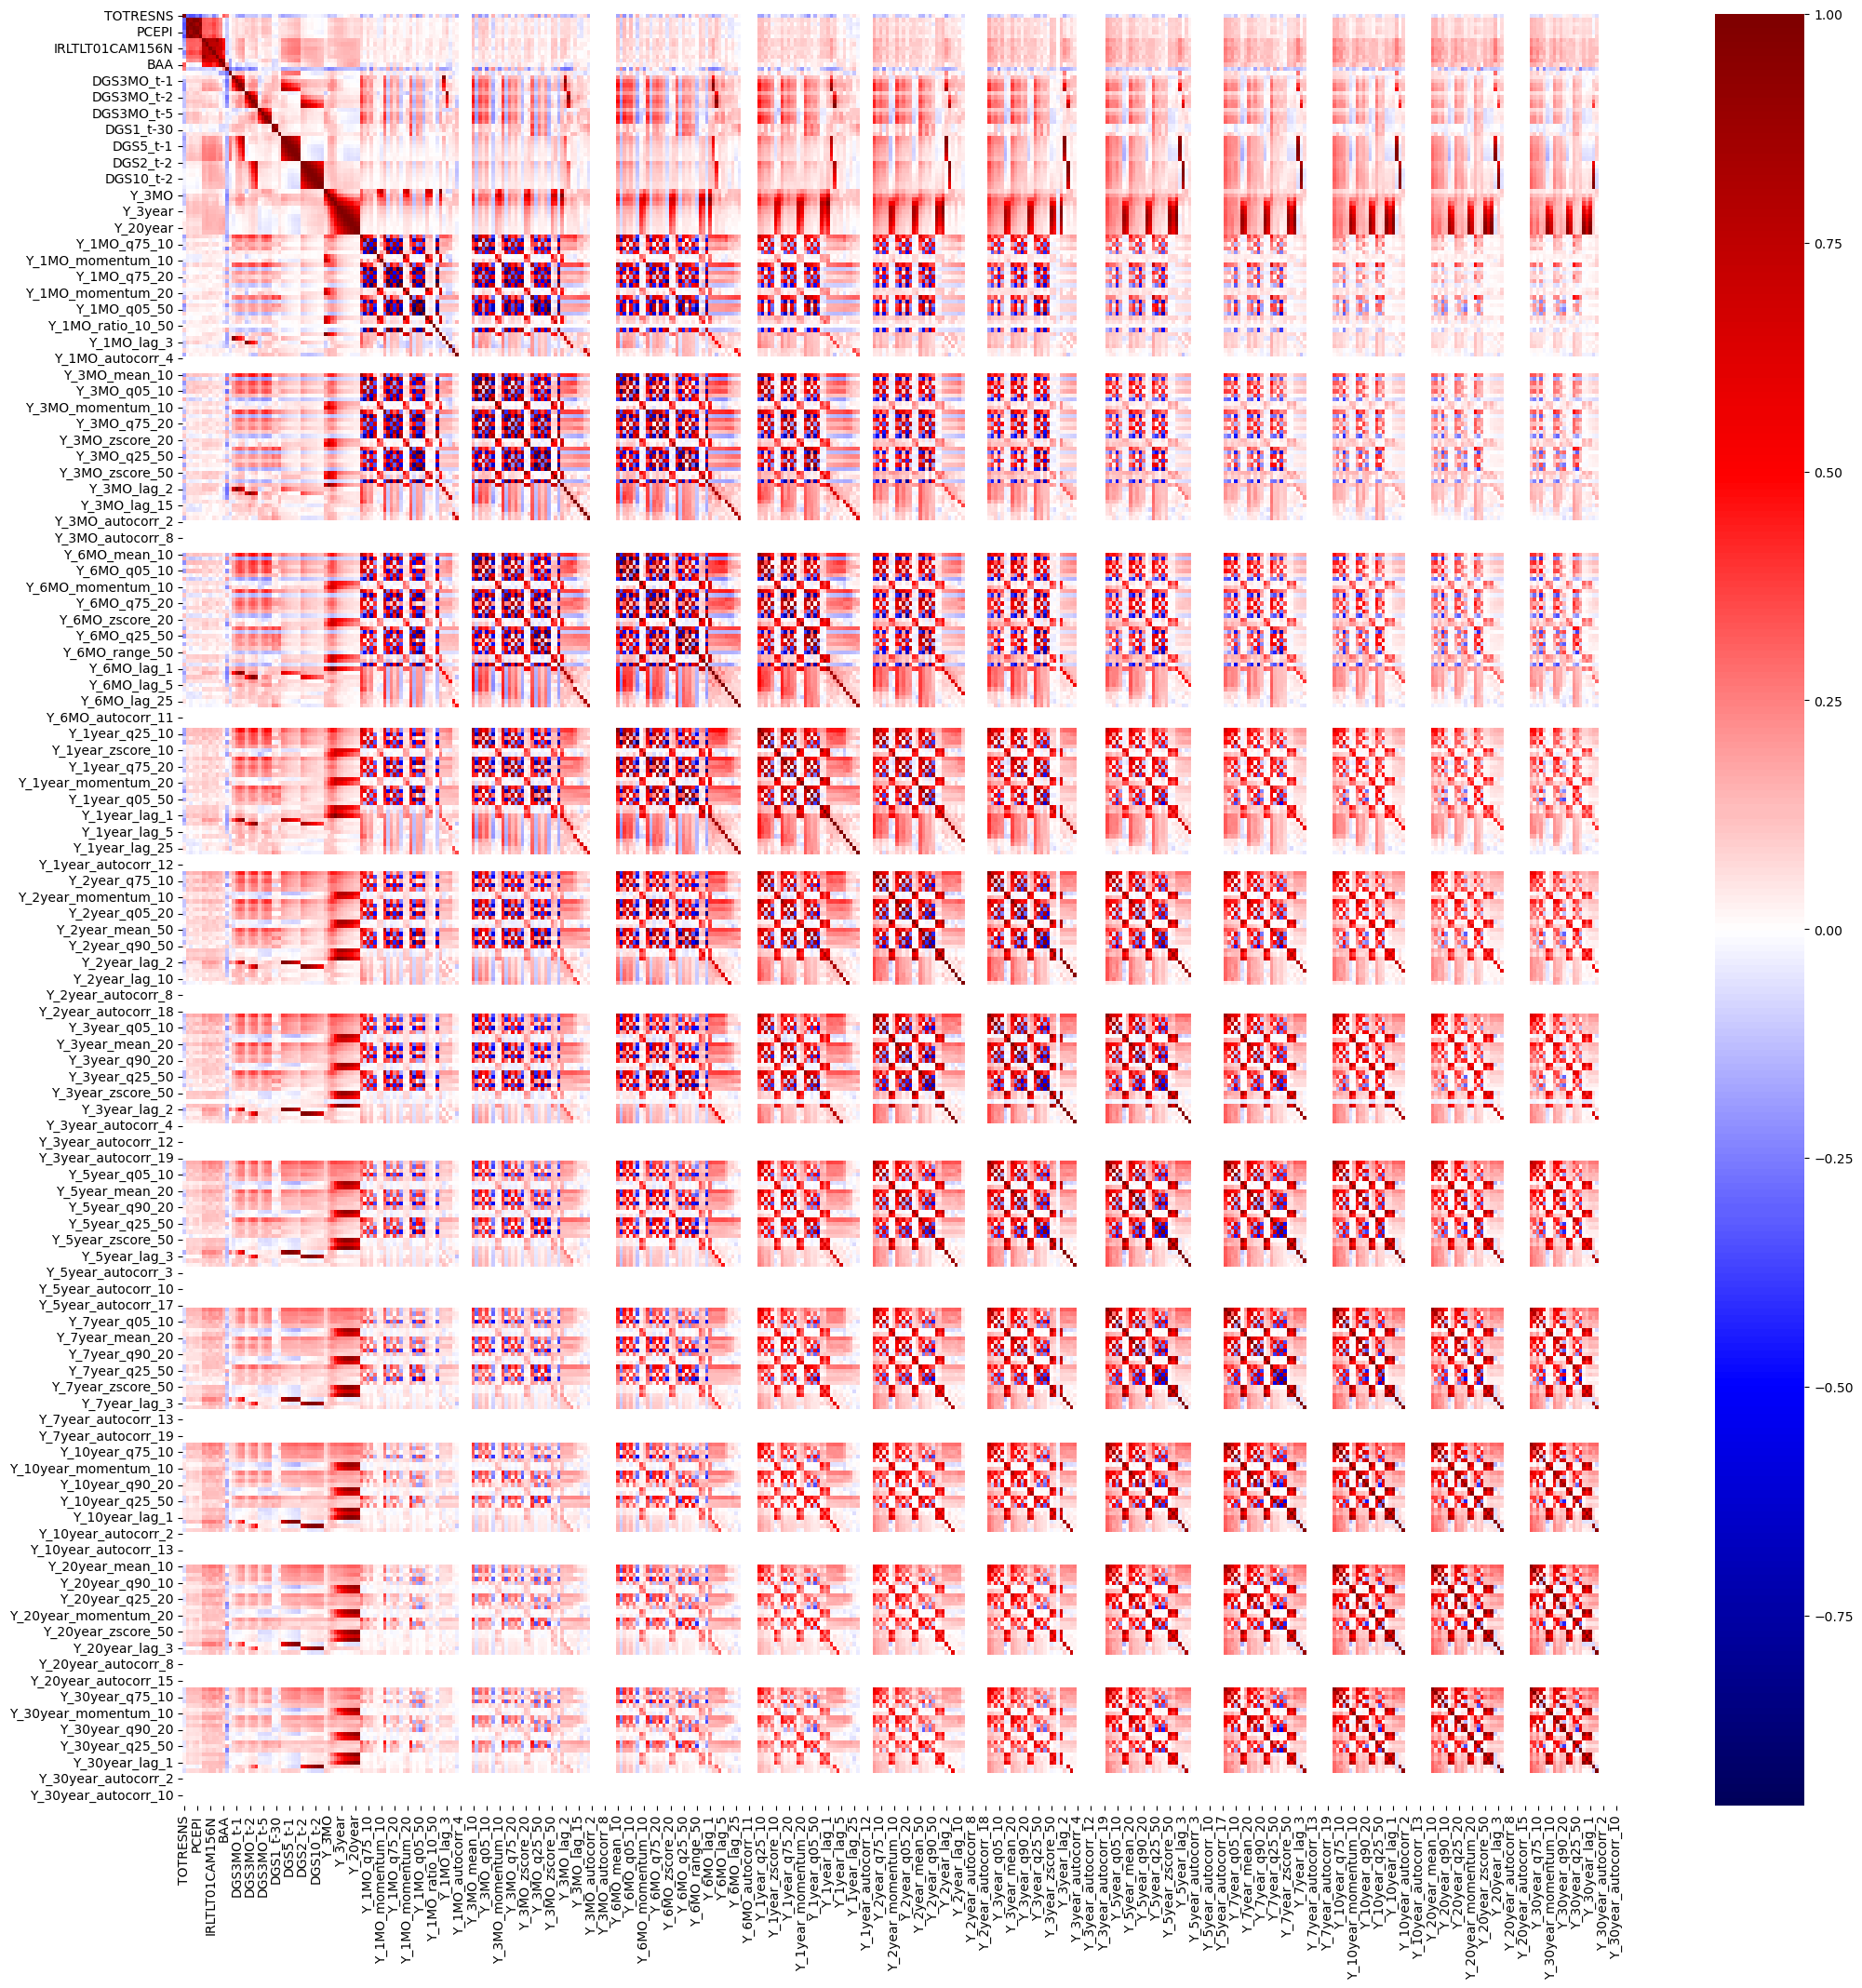

In [148]:
plt.figure(figsize=(25, 25))
sns.heatmap(dus_weekly_filtered.corr(), cmap="seismic", center=0)

#### I.2.2 - Weekly data for binary classification

Since there will also be be binary classifaction models, let's prepare the targets for that matter. Note that the classification targets are directions: does the yield go up or down from one time point to another.

In [153]:
Y_weekly

,Y_1MO,Y_3MO,Y_6MO,Y_1year,Y_2year,Y_3year,Y_5year,Y_7year,Y_10year,Y_20year,Y_30year
2004-12-03,0.01,0.04,0.05,0.03,0.01,-0.04,-0.09,-0.11,-0.11,-0.12,-0.12
2004-12-10,-0.12,-0.05,0.04,0.06,0.08,0.07,0.07,0.06,0.05,0.02,0.02
2004-12-17,-0.12,-0.01,0.06,0.03,-0.01,-0.01,-0.01,0.01,0.02,0.01,0.01
2004-12-24,0.06,0.03,0.05,0.05,0.06,0.04,0.05,0.02,0.01,-0.01,-0.04
2004-12-31,0.14,0.10,0.04,0.07,0.12,0.15,0.10,0.09,0.05,0.03,0.02
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,-0.19,-0.16,-0.08,-0.11,-0.03,-0.05,-0.02,-0.01,-0.03,-0.03,-0.02
2024-12-06,-0.14,-0.08,-0.02,0.05,0.15,0.16,0.22,0.24,0.25,0.27,0.27
2024-12-13,0.00,0.00,-0.03,0.03,0.05,0.11,0.12,0.12,0.12,0.10,0.11
2024-12-20,0.01,-0.03,0.00,-0.07,0.01,0.04,0.08,0.08,0.10,0.10,0.10


In [158]:
Yw_binary = (Y_weekly > 0).astype(int)
Xw = dus_weekly.drop(columns=Yw_binary.columns)

Our feature engineering process on the yield time series resulted in a high-dimensional dataset. To mitigate the risk of overfitting and the curse of dimensionality, a robust feature selection step is essential. We will employ a filter-based method using Mutual Information (MI), which is great at capturing non-linear relationships that simple correlation might miss.

To determine the optimal feature set, we will create several distinct subsets of the data. Each subset will contain only those features with an MI score above a specific threshold. We will test a range of thresholds—namely 0.03, 0.035, 0.04, and 0.05—and train our predictive models on each of these datasets to evaluate which level of parsimony yields the best out-of-sample performance.

In [164]:
initial_number_of_features = Xw.shape[1]

threshold_list = [0.03, 0.035, 0.04, 0.05]

datasets = {t: pd.DataFrame() for t in threshold_list}

for threshold_mi in tqdm(threshold_list):
    selected_features_w = set()
    for col in Yw_binary.columns:
        mi = mutual_info_classif(Xw, Yw_binary[col])
        top_features_i = Xw.columns[mi > threshold_mi]
        selected_features_w.update(top_features_i)

    datasets[threshold_mi] = Xw[list(selected_features_w)]

    print(
        f"{initial_number_of_features - len(selected_features_w)} features were removed for threshold {threshold_mi}."
    )
    print(
        f"So that {datasets[threshold_mi].shape[1]} features are left for that threshold {threshold_mi}."
    )
    print(
        f"Features that are left, bar target related ones are\
        \n{[col for col in datasets[threshold_mi].columns if not col.startswith(('Y', 'DGS'))]}."
    )

 25%|██▌       | 1/4 [00:09<00:29,  9.88s/it]

419 features were removed for threshold 0.03.
So that 401 features are left for that threshold 0.03.
Features that are left, bar target related ones are        
['IRLTLT01GBM156N', 'INDPRO', 'GFDEGDQ188S', 'TOTRESNS', 'BAA', 'USWTRADE', 'AAA', 'UNRATE', 'USTPU', 'CUUR0000SA0L2', 'IRLTLT01CAM156N', 'MTSDS133FMS', 'IRLTLT01JPM156N', 'USGOVT', 'UMCSENT', 'USCONS', 'IRLTLT01AUM156N', 'FGEXPND', 'IRLTLT01DEM156N', 'CURRCIR'].


 50%|█████     | 2/4 [00:19<00:19,  9.90s/it]

506 features were removed for threshold 0.035.
So that 314 features are left for that threshold 0.035.
Features that are left, bar target related ones are        
['MANEMP', 'UEMP5TO14', 'GFDEBTN', 'DTCTHFNM', 'UNRATE', 'CUUR0000SA0L2', 'IRLTLT01CAM156N', 'MTSDS133FMS', 'CUSR0000SAC', 'FYGFDPUN', 'USCONS', 'FEDFUNDS', 'IRLTLT01DEM156N', 'CURRCIR'].


 75%|███████▌  | 3/4 [00:29<00:09,  9.92s/it]

596 features were removed for threshold 0.04.
So that 224 features are left for that threshold 0.04.
Features that are left, bar target related ones are        
['UNRATE', 'USTPU', 'IRLTLT01CAM156N', 'PERMIT', 'IRLTLT01DEM156N'].


100%|██████████| 4/4 [00:39<00:00,  9.92s/it]

674 features were removed for threshold 0.05.
So that 146 features are left for that threshold 0.05.
Features that are left, bar target related ones are        
['IRLTLT01GBM156N'].


The feature selection process revealed that many of the macroeconomic and market variables sourced from FRED had low Mutual Information (MI) scores with our target. As a result, applying the MI threshold filtered out a significant portion of these exogenous features, suggesting they have a weak predictive relationship with yield directions.